In [1]:
import warnings
warnings.filterwarnings('ignore')

In [424]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pma

from tqdm import tqdm

In [3]:
plt.style.use('ggplot')

In [4]:
years = [
    2023, 2024, 2025
]

In [5]:
all_years = [
    2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025
]

In [6]:
# data = pd.DataFrame()

# for y in tqdm(years):
#     df = pd.read_csv(f'data/date-hour-soo-dest-{y}.csv').T.reset_index().T
#     data = pd.concat([data, df], axis=0)

# data.head()

In [7]:
full_data = pd.DataFrame()

for y in tqdm(all_years):
    df = pd.read_csv(f'data/date-hour-soo-dest-{y}.csv').T.reset_index().T
    full_data = pd.concat([full_data, df], axis=0)

full_data.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.54s/it]


,0,1,2,3,4
index,2018-01-01,0,12TH,12TH.1,3
0,2018-01-01,0,12TH,16TH,1
1,2018-01-01,0,12TH,BAYF,1
2,2018-01-01,0,12TH,CAST,3
3,2018-01-01,0,12TH,CIVC,2


In [46]:
full_data[0] = pd.to_datetime(full_data[0])

data = full_data[
    full_data[0] >= pd.to_datetime('2023-01-01')
]

In [47]:
data.shape, full_data.shape

((23805046, 5), (64802259, 5))

In [48]:
data = data.rename({
   0: 'date',
   1: 'hour',
    2: 'origin',
    3: 'dest',
    4: 'riders'
}, axis=1)
data.head(1)

,date,hour,origin,dest,riders
index,2023-01-01,0,12TH,12TH.1,1


In [49]:
full_data = full_data.rename({
   0: 'date',
   1: 'hour',
    2: 'origin',
    3: 'dest',
    4: 'riders'
}, axis=1)
full_data.head(1)

,date,hour,origin,dest,riders
index,2018-01-01,0,12TH,12TH.1,3


Station codes in the dictionary below from BART Legacy API website: https://api.bart.gov/docs/overview/abbrev.aspx

In [51]:
station_codes = {
    "12TH": "12th St. Oakland City Center",
    "16TH": "16th St. Mission (SF)",
    "19TH": "19th St. Oakland",
    "24TH": "24th St. Mission (SF)",
    "ASHB": "Ashby (Berkeley)",
    "ANTC": "Antioch",
    "BALB": "Balboa Park (SF)",
    "BAYF": "Bay Fair (San Leandro)",
    "BERY": "Berryessa / North San Jose",
    "CAST": "Castro Valley",
    "CIVC": "Civic Center (SF)",
    "COLS": "Coliseum",
    "COLM": "Colma",
    "CONC": "Concord",
    "DALY": "Daly City",
    "DBRK": "Downtown Berkeley",
    "DUBL": "Dublin/Pleasanton",
    "DELN": "El Cerrito del Norte",
    "PLZA": "El Cerrito Plaza",
    "EMBR": "Embarcadero (SF)",
    "FRMT": "Fremont",
    "FTVL": "Fruitvale (Oakland)",
    "GLEN": "Glen Park (SF)",
    "HAYW": "Hayward",
    "LAFY": "Lafayette",
    "LAKE": "Lake Merritt (Oakland)",
    "MCAR": "MacArthur (Oakland)",
    "MLBR": "Millbrae",
    "MLPT": "Milpitas",
    "MONT": "Montgomery St. (SF)",
    "NBRK": "North Berkeley",
    "NCON": "North Concord/Martinez",
    "OAKL": "Oakland Int'l Airport",
    "ORIN": "Orinda",
    "PITT": "Pittsburg/Bay Point",
    "PCTR": "Pittsburg Center",
    "PHIL": "Pleasant Hill",
    "POWL": "Powell St. (SF)",
    "RICH": "Richmond",
    "ROCK": "Rockridge (Oakland)",
    "SBRN": "San Bruno",
    "SFIA": "San Francisco Int'l Airport",
    "SANL": "San Leandro",
    "SHAY": "South Hayward",
    "SSAN": "South San Francisco",
    "UCTY": "Union City",
    "WARM": "Warm Springs/South Fremont",
    "WCRK": "Walnut Creek",
    "WDUB": "West Dublin",
    "WOAK": "West Oakland"
}

In [52]:
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['hour'].astype(int)
data['riders'] = data['riders'].astype(int)

In [53]:
full_data['hour'] = full_data['hour'].astype(int)
full_data['riders'] = full_data['riders'].astype(int)

In [54]:
data['day_of_wk'] = data['date'].dt.day_name()
data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2023-01-01,0,12TH,12TH.1,1,Sunday
0,2023-01-01,0,12TH,16TH,1,Sunday
1,2023-01-01,0,12TH,19TH,2,Sunday
2,2023-01-01,0,12TH,24TH,3,Sunday
3,2023-01-01,0,12TH,ASHB,2,Sunday


In [55]:
full_data['day_of_wk'] = full_data['date'].dt.day_name()
full_data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2018-01-01,0,12TH,12TH.1,3,Monday
0,2018-01-01,0,12TH,16TH,1,Monday
1,2018-01-01,0,12TH,BAYF,1,Monday
2,2018-01-01,0,12TH,CAST,3,Monday
3,2018-01-01,0,12TH,CIVC,2,Monday


In [56]:
data_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
full_data_wkday = full_data[full_data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

In [57]:
# Get dataframe with average riders for each route per hour, only aggregating weekdays
routes_by_hr_wkday = data_wkday[['hour', 'origin', 'dest', 'riders']].groupby(['hour', 'origin', 'dest']).agg('mean')
routes_by_hr_wkday.shape

(53947, 1)

In [58]:
routes_by_hr_wkday = routes_by_hr_wkday.reset_index()
routes_by_hr_wkday.head()

,hour,origin,dest,riders
0,0,12TH,12TH,1.891089
1,0,12TH,12TH.1,2.000000
2,0,12TH,16TH,1.400990
3,0,12TH,19TH,1.085106
4,0,12TH,24TH,1.410138


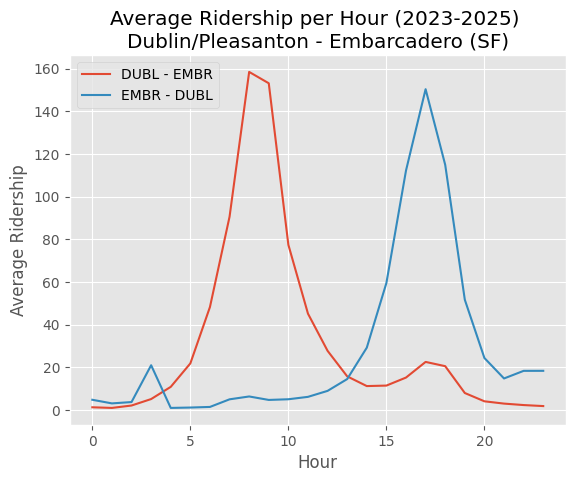

In [59]:
## Average ridership per hour for a specific route

station_1_lower = "dubl"
station_2_lower = "embr"

station_1 = station_1_lower.upper()
station_2 = station_2_lower.upper()

station_1_fullname = station_codes[station_1]
station_2_fullname = station_codes[station_2]

plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['riders'],
    label = f'{station_1} - {station_2}'
)
plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['riders'],
    label = f'{station_2} - {station_1}'
)
plt.xlabel('Hour')
plt.ylabel('Average Ridership')
plt.title(f'Average Ridership per Hour (2023-2025) \n{station_1_fullname} - {station_2_fullname}')
plt.legend();

In [60]:
exits_by_hr = data[['date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
).agg('mean').reset_index()
exits_by_hr.head()

,hour,dest,date,riders
0,0,12TH,2024-05-02 07:04:18.726899456,29.185832
1,0,12TH.1,2023-07-02 12:00:00.000000000,1.500000
2,0,16TH,2024-05-02 12:00:00.000000000,30.288934
3,0,19TH,2024-05-02 07:04:18.726899456,31.010267
4,0,24TH,2024-05-02 12:00:00.000000000,33.339139


In [61]:
exits_by_hr.shape

(1201, 4)

In [62]:
exits_by_hr_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])][[
 'date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
 ).agg('mean').reset_index()
exits_by_hr_wkday.head()

,hour,dest,date,riders
0,0,12TH,2024-05-02 09:38:28.751793408,23.286944
1,0,12TH.1,2024-01-01 00:00:00.000000000,2.000000
2,0,16TH,2024-05-02 09:38:28.751793408,22.441894
3,0,19TH,2024-05-02 09:38:28.751793408,22.885222
4,0,24TH,2024-05-02 09:38:28.751793408,25.446198


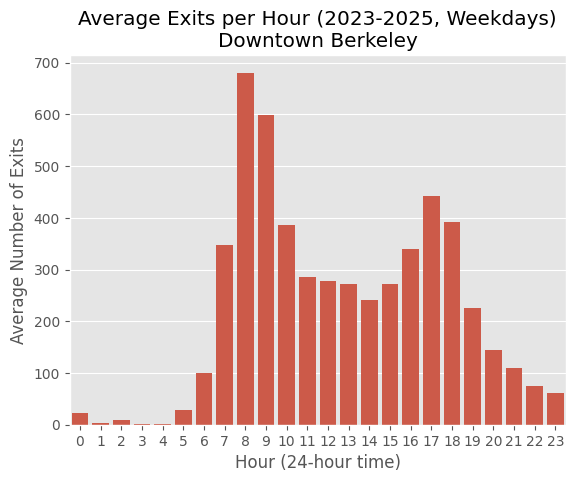

In [63]:
station_lower = 'dbrk'
station = station_lower.upper()
station_fullname = station_codes[station]

sns.barplot(
    data = exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station],
    x = 'hour',
    y = 'riders'
)
plt.xlabel('Hour (24-hour time)')
plt.ylabel('Average Number of Exits')
plt.title(f'Average Exits per Hour (2023-2025, Weekdays)\n{station_fullname}');

In [64]:
np.sum(exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station]['riders'])

5316.866800757514

## Arrivals/Departures & Land Use

As described in the [BART Ridership snapshot for April 2025](https://www.bart.gov/sites/default/files/2025-05/202504%20Monthly%20Ridership%20Snapshot.pdf), the arrivals/departures ratio during AM commute times can be useful as a proxy for land use. Stations with more departures are likely to have more residential land use (housing-focused), whereas stations with more arrivals are likely to have more commerical, industrial, and office land use (jobs-focused). Those with a balance between arrivals and departures during AM commute times have more balanced land use. Note that this is a general proxy and may not be applicable in certain cases, i.e. arrivals/departures from SF and Oakland Int'l airports.

The ridership snapshot provides a handy chart for this, but it is limited in readability. We can visualize and analyze arrival/departure ratio with hourly ridership data.

In [66]:
# Filter for AM commute times on weekdays
am_commutes = data[
    (data['hour'] >= 4) & (data['hour'] <= 11) & (~data['day_of_wk'].isin(['Sunday', 'Saturday']))
]
am_commutes.head()

,date,hour,origin,dest,riders,day_of_wk
16218,2023-01-02,4,12TH,12TH,2,Monday
16219,2023-01-02,4,ANTC,ANTC,1,Monday
16220,2023-01-02,4,ANTC,PCTR,1,Monday
16221,2023-01-02,4,BALB,BALB,2,Monday
16222,2023-01-02,4,CIVC,CIVC,1,Monday


In [67]:
am_commutes.shape

(6462513, 6)

In [68]:
departures_am = am_commutes.groupby(['origin']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'departures'}, axis=1)
exits_am = am_commutes.groupby(['dest']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'arrivals'}, axis=1)
departures_am.head()

,origin,departures
0,12TH,1105282
1,16TH,1034370
2,19TH,1217866
3,24TH,1544874
4,ANTC,969531


In [69]:
exits_am.head()

,dest,arrivals
0,12TH,1695730
1,16TH,1556570
2,19TH,1298910
3,24TH,1090187
4,ANTC,101070


In [70]:
deps_arrs = pd.merge(left=departures_am, right=exits_am, left_on='origin', right_on='dest').drop(['dest'], axis=1).rename(
    {
        'origin': 'station_code'
    }, axis=1
)
deps_arrs['station_name'] = deps_arrs['station_code'].map(lambda x: station_codes[x])
deps_arrs['arr_dep_ratio'] = deps_arrs['arrivals'] / deps_arrs['departures']
deps_arrs['arr_pct'] = deps_arrs['arrivals'] / (deps_arrs['arrivals'] + deps_arrs['departures']) * 100
deps_arrs = deps_arrs[['station_code', 'station_name', 'departures', 'arrivals', 'arr_dep_ratio', 'arr_pct']]
deps_arrs.head()

,station_code,station_name,departures,arrivals,arr_dep_ratio,arr_pct
0,12TH,12th St. Oakland City Center,1105282,1695730,1.534206,60.539905
1,16TH,16th St. Mission (SF),1034370,1556570,1.504848,60.077424
2,19TH,19th St. Oakland,1217866,1298910,1.066546,51.610076
3,24TH,24th St. Mission (SF),1544874,1090187,0.705680,41.372363
4,ANTC,Antioch,969531,101070,0.104246,9.440492


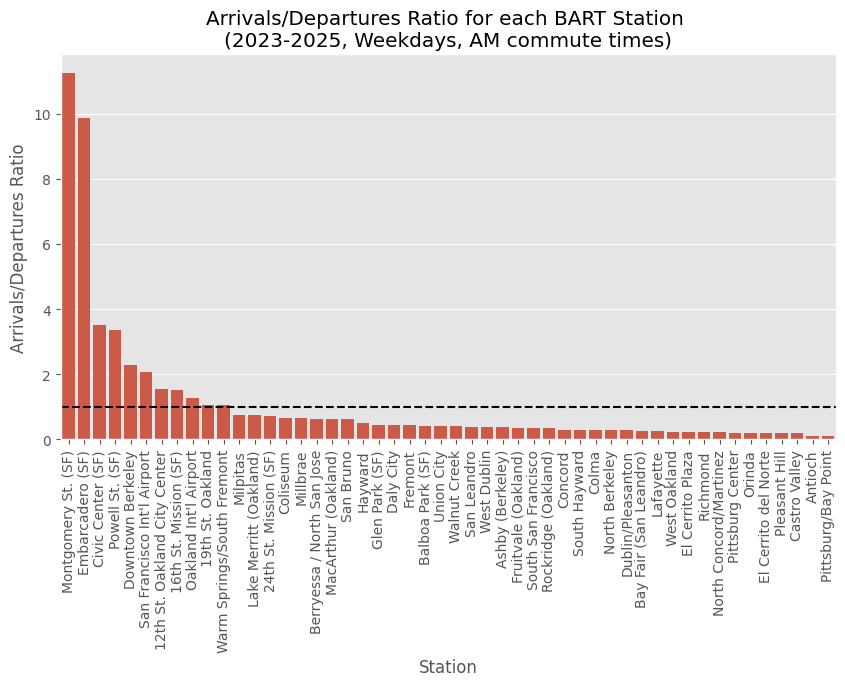

In [71]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = deps_arrs.sort_values(['arr_dep_ratio'], ascending=False),
    x = 'station_name',
    y = 'arr_dep_ratio'
)
plt.xlabel('Station')
plt.ylabel('Arrivals/Departures Ratio')
plt.title('Arrivals/Departures Ratio for each BART Station \n(2023-2025, Weekdays, AM commute times)')
plt.xticks(rotation=90)
plt.axhline(y = 1, color='black', linestyle = '--');

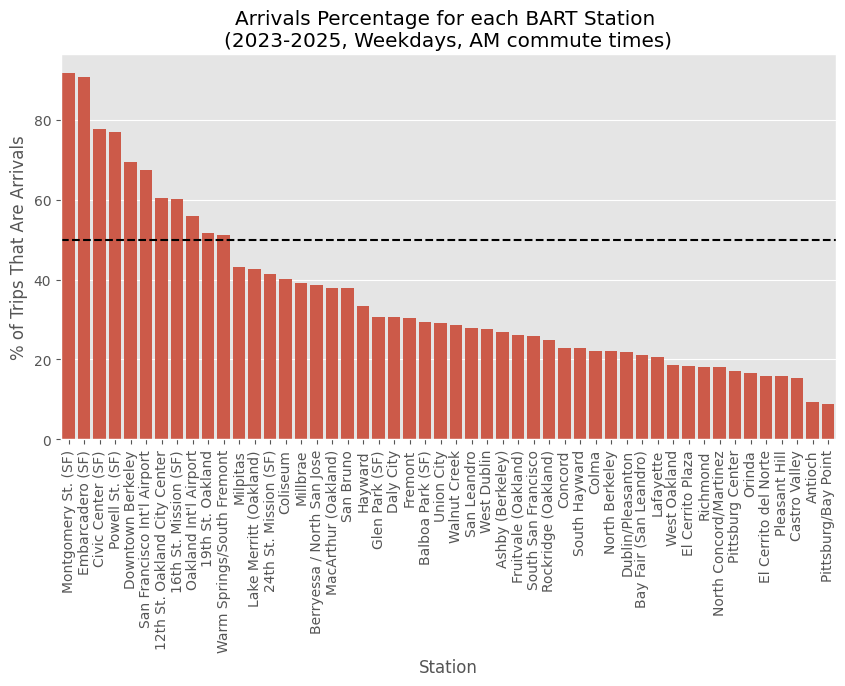

In [72]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = deps_arrs.sort_values(['arr_pct'], ascending=False),
    x = 'station_name',
    y = 'arr_pct'
)
plt.xlabel('Station')
plt.ylabel('% of Trips That Are Arrivals')
plt.title('Arrivals Percentage for each BART Station \n(2023-2025, Weekdays, AM commute times)')
plt.xticks(rotation=90)
plt.axhline(y = 50, color='black', linestyle = '--');

## Where From?

[Hundreds of thousands](https://www.bart.gov/news/articles/2025/news20250109-1) of people use BART everyday. Many stations - both city center and suburban - have average weekday riderships in the thousands. So we can ask, given a specific station $X$, where are people who exit at $X$ departing from _on the average day_?

In [74]:
exit_stat_lower = 'dbrk'
exit_stat = exit_stat_lower.upper()
exit_stat_fullname = station_codes[exit_stat]

In [75]:
exits_at_stat = data_wkday[data_wkday['dest'] == exit_stat].groupby(['date', 'origin']).agg({'riders': 'sum'})
exits_at_stat = exits_at_stat.reset_index().groupby(['origin']).agg({'riders': 'mean'}).reset_index().sort_values(by=['riders'], ascending=False)
exits_at_stat['origin_fullname'] = exits_at_stat['origin'].map(lambda x: station_codes[x])
exits_at_stat = exits_at_stat[['origin', 'origin_fullname', 'riders']]
exits_at_stat.head()

,origin,origin_fullname,riders
18,EMBR,Embarcadero (SF),432.959828
16,DELN,El Cerrito del Norte,409.539455
37,POWL,Powell St. (SF),322.103300
28,MONT,Montgomery St. (SF),321.294118
36,PLZA,El Cerrito Plaza,309.529412


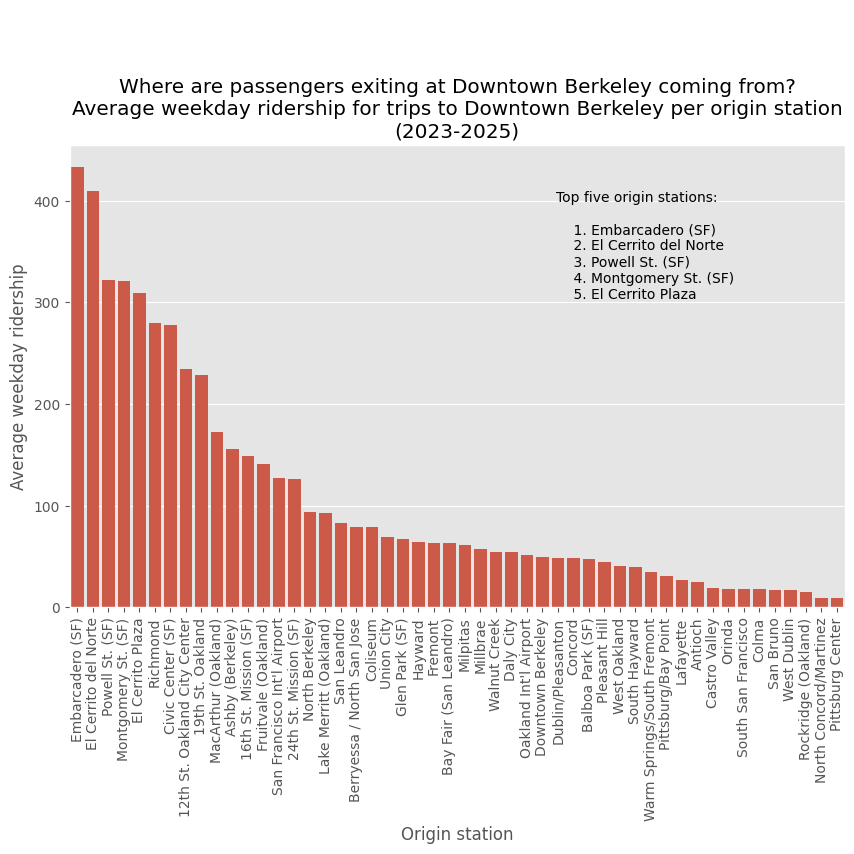

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data = exits_at_stat,
    x = 'origin_fullname',
    y = 'riders'
)

plt.xlabel('Origin station')
plt.ylabel('Average weekday ridership')
plt.title(f'''Where are passengers exiting at {exit_stat_fullname} coming from?
Average weekday ridership for trips to {exit_stat_fullname} per origin station\n(2023-2025)''')
plt.annotate(
    text = f'''Top five origin stations:\n
    1. {exits_at_stat.iloc[0, 1]}
    2. {exits_at_stat.iloc[1, 1]}
    3. {exits_at_stat.iloc[2, 1]}
    4. {exits_at_stat.iloc[3, 1]}
    5. {exits_at_stat.iloc[4, 1]}''',
    xycoords = 'figure points',
    xy = (400, 400),
    xytext = (400, 400)
)
plt.xticks(rotation=90);

We can narrow this down to AM commute times to get a picture of who is commuting from where to station $X$ for work or school.

In [78]:
exits_at_stat_am = data_wkday[
    (data_wkday['dest'] == exit_stat) & (data_wkday['hour'] >= 4) & (data_wkday['hour'] <= 11)
    ].groupby(['date', 'origin']).agg({'riders': 'sum'})
exits_at_stat_am = exits_at_stat_am.reset_index().groupby(['origin']).agg({'riders': 'mean'}).reset_index().sort_values(by=['riders'], ascending=False)
exits_at_stat_am['origin_fullname'] = exits_at_stat_am['origin'].map(lambda x: station_codes[x])
exits_at_stat_am = exits_at_stat_am[['origin', 'origin_fullname', 'riders']]
exits_at_stat_am.head()

,origin,origin_fullname,riders
16,DELN,El Cerrito del Norte,287.104735
36,PLZA,El Cerrito Plaza,189.893831
38,RICH,Richmond,182.369253
2,19TH,19th St. Oakland,99.531609
0,12TH,12th St. Oakland City Center,98.573888


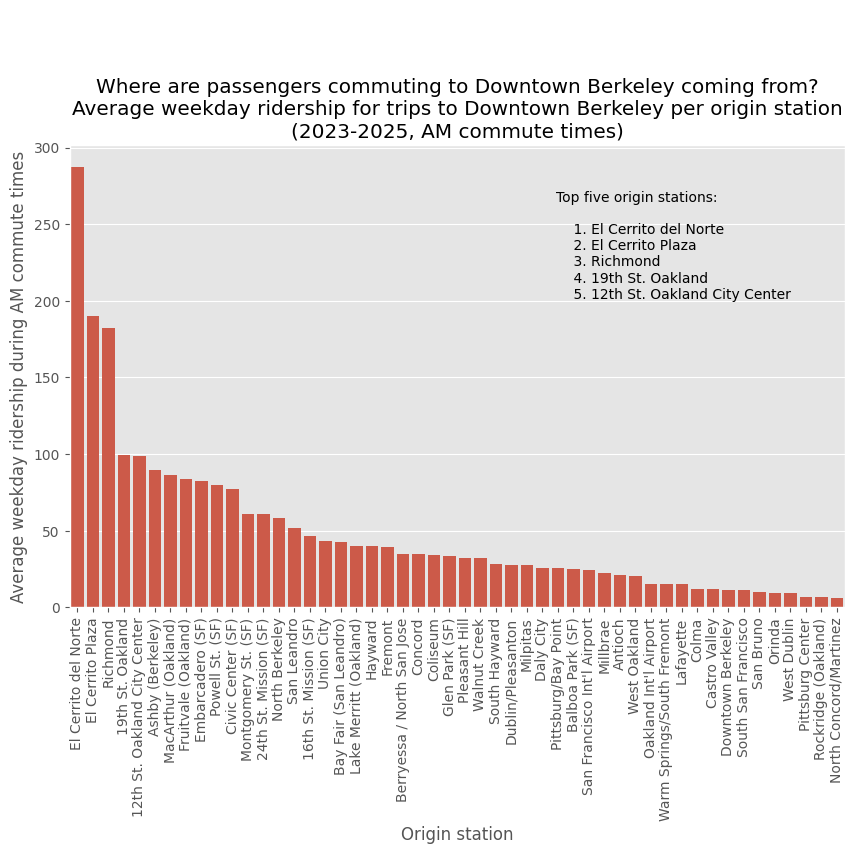

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data = exits_at_stat_am,
    x = 'origin_fullname',
    y = 'riders'
)

plt.xlabel('Origin station')
plt.ylabel('Average weekday ridership during AM commute times')
plt.title(f'''Where are passengers commuting to {exit_stat_fullname} coming from?
Average weekday ridership for trips to {exit_stat_fullname} per origin station\n(2023-2025, AM commute times)''')
plt.annotate(
    text = f'''Top five origin stations:\n
    1. {exits_at_stat_am.iloc[0, 1]}
    2. {exits_at_stat_am.iloc[1, 1]}
    3. {exits_at_stat_am.iloc[2, 1]}
    4. {exits_at_stat_am.iloc[3, 1]}
    5. {exits_at_stat_am.iloc[4, 1]}''',
    xycoords = 'figure points',
    xy = (400, 400),
    xytext = (400, 400)
)
plt.xticks(rotation=90);

## Ridership Patterns & Trends

The pandemic and the rise of remote work has caused ridership on public transit networks around the country, including BART, to drop - many still haven't recovered. How well has the recovery been going?

In [148]:
# full_data['date'] = pd.to_datetime(full_data['date'])

In [372]:
daily_riders_full = full_data.groupby(['date']).agg({'riders': 'sum'})# |.reset_index()
daily_riders_full.head()

,riders
date,
2018-01-01,110254
2018-01-02,332343
2018-01-03,361718
2018-01-04,369714
2018-01-05,347483


In [373]:
n = 14
moving_avg_riders = daily_riders_full.rolling(n).mean()[n-1:].reset_index()
daily_riders_full = daily_riders_full.reset_index()
moving_avg_riders.head()

,date,riders
0,2018-01-14,285906.000000
1,2018-01-15,291002.428571
2,2018-01-16,296694.714286
3,2018-01-17,300493.071429
4,2018-01-18,303478.142857


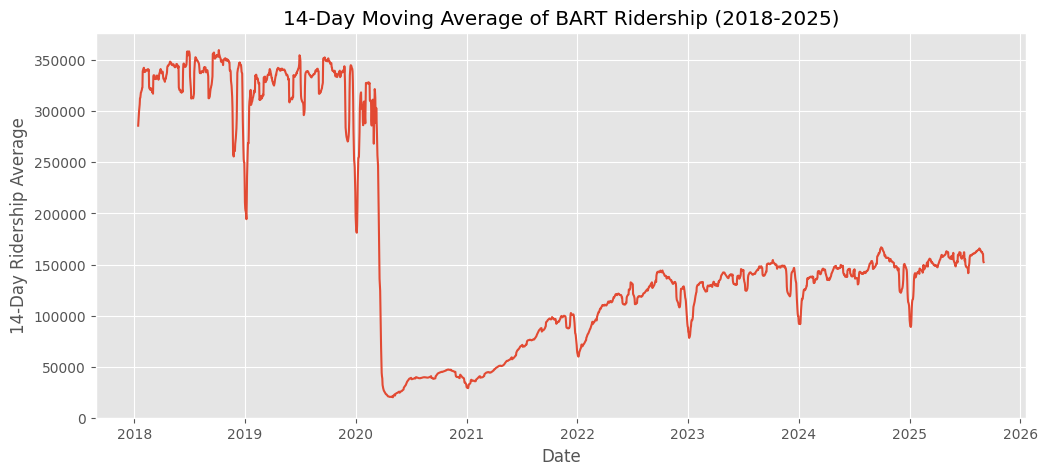

In [378]:
plt.figure(figsize=(12, 5))
plt.plot(moving_avg_riders['date'], moving_avg_riders['riders'])
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Average')
plt.title('14-Day Moving Average of BART Ridership (2018-2025)')
plt.ylim(bottom=0);

In [152]:
pre_covid_data = full_data[
    (full_data['date'] <= pd.to_datetime('2020-02-01'))
]
pre_covid_data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2018-01-01,0,12TH,12TH.1,3,Monday
0,2018-01-01,0,12TH,16TH,1,Monday
1,2018-01-01,0,12TH,BAYF,1,Monday
2,2018-01-01,0,12TH,CAST,3,Monday
3,2018-01-01,0,12TH,CIVC,2,Monday


In [153]:
pre_covid_data.shape

(21169703, 6)

In [154]:
post_covid_data = full_data[
    (full_data['date'] >= pd.to_datetime('2021-11-01'))
]
post_covid_data.head()

,date,hour,origin,dest,riders,day_of_wk
5334271,2021-11-01,0,12TH,24TH,2,Monday
5334272,2021-11-01,0,12TH,ASHB,1,Monday
5334273,2021-11-01,0,12TH,DALY,2,Monday
5334274,2021-11-01,0,12TH,FRMT,1,Monday
5334275,2021-11-01,0,12TH,MLPT,2,Monday


In [155]:
### How has ridership held up by station?

pre_covid_stations = pre_covid_data.groupby(['dest', 'date']).agg({'riders': 'sum'}).groupby(['dest']).agg({'riders': 'mean'}).reset_index()
pre_covid_stations.head()

,dest,riders
0,12TH,10630.118265
1,12TH.1,3.000000
2,16TH,10365.231275
3,19TH,10400.091984
4,24TH,9932.542707


In [156]:
post_covid_stations = post_covid_data.groupby(['dest', 'date']).agg({'riders': 'sum'}).groupby(['dest']).agg({'riders': 'mean'}).reset_index()
post_covid_stations.head()

,dest,riders
0,12TH,3734.545649
1,12TH.1,1.333333
2,16TH,4678.787447
3,19TH,3589.354494
4,24TH,4488.716833


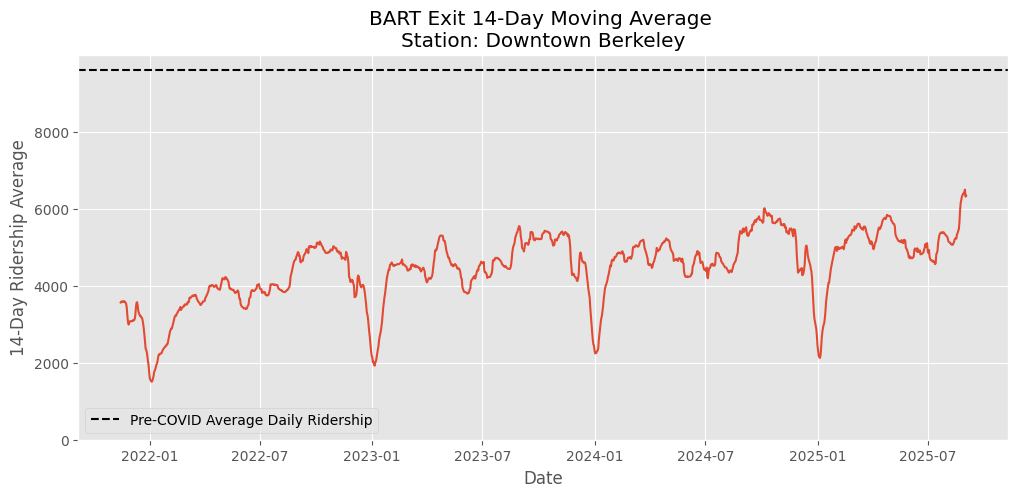

In [428]:
## Edit this to change station
station_lower = "dbrk"

##################################
station = station_lower.upper()
station_fullname = station_codes[station]

## All days
pre_cov_stat = pre_covid_data[
    (pre_covid_data['dest'] == station) # & (~pre_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'}).reset_index()
post_cov_stat = post_covid_data[
    (post_covid_data['dest'] == station) # & (~post_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'})# .reset_index()

pre_cov_daily_avg = np.mean(pre_cov_stat['riders'])

post_cov_rolling = post_cov_stat.rolling(14).mean().reset_index()[6:]

plt.figure(figsize=(12, 5))
plt.plot(
    post_cov_rolling['date'],
    post_cov_rolling['riders']
)
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Average')
plt.title(f'BART Exit 14-Day Moving Average \nStation: {station_fullname}')
plt.axhline(y = pre_cov_daily_avg, label='Pre-COVID Average Daily Ridership', color = 'black', linestyle = '--')
plt.ylim(bottom=0)
plt.legend();

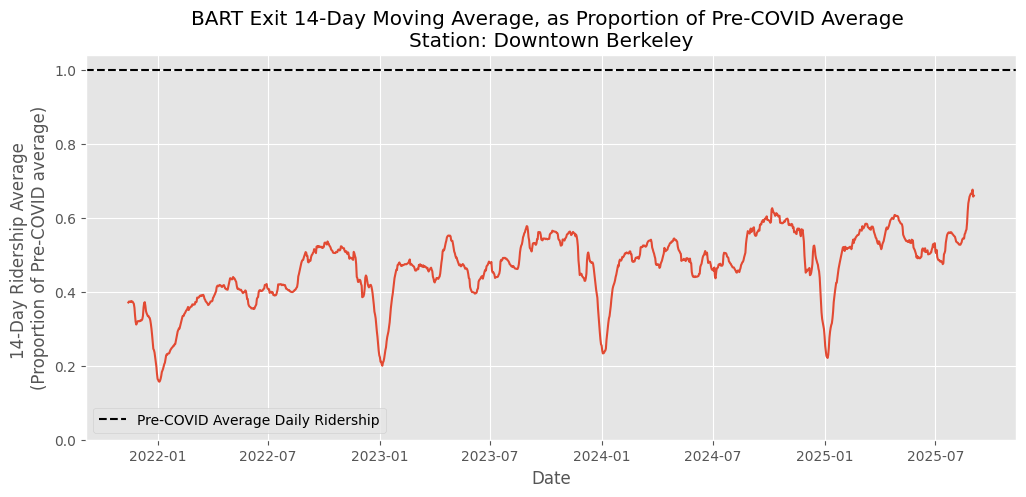

In [429]:
## Same as above, but as a proportion/fraction of pre-COVID average

## All days
pre_cov_stat = pre_covid_data[
    (pre_covid_data['dest'] == station) # & (~pre_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'}).reset_index()
post_cov_stat = post_covid_data[
    (post_covid_data['dest'] == station) # & (~post_covid_data['day_of_wk'].isin(['Sunday', 'Saturday']))
].groupby(['date']).agg({'riders': 'sum'})# .reset_index()

pre_cov_daily_avg = np.mean(pre_cov_stat['riders'])

post_cov_rolling = post_cov_stat.rolling(14).mean().reset_index()[6:]
post_cov_rolling['riders'] = post_cov_rolling['riders'] / pre_cov_daily_avg

plt.figure(figsize=(12, 5))
plt.plot(
    post_cov_rolling['date'],
    post_cov_rolling['riders']
)
plt.xlabel('Date')
plt.ylabel('14-Day Ridership Average \n(Proportion of Pre-COVID average)')
plt.title(f'BART Exit 14-Day Moving Average, as Proportion of Pre-COVID Average \nStation: {station_fullname}')
plt.axhline(y = 1, label='Pre-COVID Average Daily Ridership', color = 'black', linestyle = '--')
plt.ylim(bottom=0)
plt.legend();

## Projecting Future Ridership Trends
Where we use SARIMA and potentially other methods to project future ridership trends.

In [460]:
daily_riders_full['month'] = daily_riders_full['date'].dt.month_name()
daily_riders_full['year'] = daily_riders_full['date'].map(lambda x: x.year)
daily_riders_full.head()

,date,riders,month,year
0,2018-01-01,110254,January,2018
1,2018-01-02,332343,January,2018
2,2018-01-03,361718,January,2018
3,2018-01-04,369714,January,2018
4,2018-01-05,347483,January,2018


In [464]:
## Differencing
daily_diff = daily_riders_full.set_index(['date', 'month', 'year']).diff().reset_index()
daily_diff.head()

,date,month,year,riders
0,2018-01-01,January,2018,NaN
1,2018-01-02,January,2018,222089.0
2,2018-01-03,January,2018,29375.0
3,2018-01-04,January,2018,7996.0
4,2018-01-05,January,2018,-22231.0


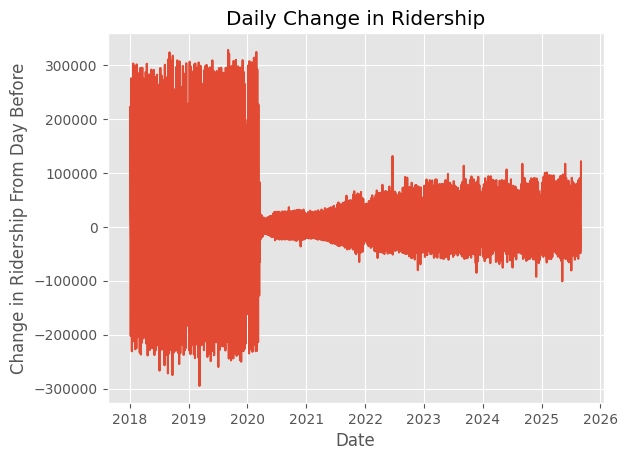

In [466]:
plt.plot(
    daily_diff['date'],
    daily_diff['riders']
)
plt.xlabel('Date')
plt.ylabel('Change in Ridership From Day Before')
plt.title('Daily Change in Ridership');

In [470]:
## Monthly change
monthly_riders_full = daily_riders_full.groupby(['month', 'year']).agg({'riders': 'sum'}).reset_index()
monthly_riders_full.head()

,month,year,riders
0,April,2018,10049472
1,April,2019,10312623
2,April,2020,622953
3,April,2021,1534665
4,April,2022,3421101


In [472]:
monthly_riders_full.shape

(93, 3)

In [476]:
monthly_riders_full['date'] = pd.to_datetime(monthly_riders_full["month"] + " " + monthly_riders_full["year"].astype(str))
monthly_riders_full.head()

,month,year,riders,date
0,April,2018,10049472,2018-04-01
1,April,2019,10312623,2019-04-01
2,April,2020,622953,2020-04-01
3,April,2021,1534665,2021-04-01
4,April,2022,3421101,2022-04-01


In [478]:
## To be continued...